**This notebook walks through iterative modeling. Nine different variations of data were tried across mostly untuned Decision Trees and Random Forest classifiers. Tried a KNN with the dataset that got the best results from these (DV7) and tried KNN model - but metrics did not compare. Stick with Random Forest and tune in notebook 92_**

Business problem: Customers get Peloton bike delivered and ask, what class should I take first?

Difficulty will be basis of how they choose - build model to predict difficulty based on class daya including roll up stats of playlist.

- False Positive - a class is labeled easy, but it isn't
- False Negative - a class is not labeled easy, but it is

**Both are equally important to account for - use F1 Score**

Note: A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, **micro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).**
Source: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

In [1]:
# Basics 
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import math
import operator 
import matplotlib.pyplot as plt
%matplotlib inline

# Importing dfs with heavy processing
import pickle

# Imports Modeling
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, plot_confusion_matrix

# Feat Imp
from yellowbrick.model_selection import FeatureImportances

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
# Just in case other pickle files available
# Opening pickle files
# Use classId where you can as key for merging
base_clean_df = pd.read_pickle("../../data/pickled_dfs/base_clean_df.pkl")
artist_df = pd.read_pickle("../../data/pickled_dfs/artist_df.pkl")
artist_id_class_count = pd.read_pickle("../../data/pickled_dfs/larger_spot_artist_id_class_count.pkl")  # has artist features
songs_df = pd.read_pickle("../../data/pickled_dfs/songs_df.pkl")
song_class_count_df = pd.read_pickle("../../data/pickled_dfs/song_class_count_df.pkl")
song_class_count_df.rename(columns={'Artist':'Song'}, inplace=True) # Quick clean rename column
class_type_reorg_df = pd.read_pickle("../../data/pickled_dfs/class_type_reorg_df.pkl")
new_class_types_with_artists = pd.read_pickle("../../data/pickled_dfs/new_class_types_with_artists.pkl")
master_song_df = pd.read_pickle("../../data/pickled_dfs/master_song_df.pkl") # has song features
# artist_id_class_count has 186 rows with 0LyfQWJT6nXafLPZqxe9Of - it means Various Artists
# and 40 errors

In [3]:
df = pd.read_pickle("../../data/pickled_dfs/master_first_classes_with_stats.pkl")
df.head()

,classId,className,classDescription,classDifficulty,classDuration,classType,classLength,classLocation,classOriginalAirdate,classRating,classRatingCount,instructorName,instructorBio,classEquipment,classSongs,classArtists,classUrl,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory
0,9680a817bf2149d2b91990c87166a400,20 min Pop Ride,We dare you not to dance as you ride to all th...,7.4000,20,Cycling,24,uk,2021-09-03 07:52:00,1.0000,82,Sam Yo,Sam is a pro at many things but shines when it...,Bike,"Señorita,Marry You,Irreplaceable,What Do You M...","Justin Timberlake,Bruno Mars,Beyoncé,Justin Bi...",https://members.onepeloton.com/classes/bootcam...,65.0,0.0,0.6675,0.6635,7.5,-5.1020,1.0,0.05940,0.243500,0.000711,0.1355,0.6470,116.5345,4.0,18846591.5,86.0,3.611225,Music
1,932f15ed407f46049988ba4c46e3ee3b,20 min HIIT Ride,"Powerful and efficient, this high-intensity in...",7.7203,20,Cycling,24,uk,2021-09-03 07:25:00,0.9889,90,Sam Yo,Sam is a pro at many things but shines when it...,Bike,Just Like Fire (From the Original Motion Pictu...,"P!nk,P!nk,Justin Bieber,Britney Spears,London ...",https://members.onepeloton.com/classes/bootcam...,33.5,0.0,0.6625,0.7610,4.5,-6.5125,1.0,0.05405,0.002405,0.001189,0.0946,0.4025,129.5015,4.0,9809178.0,85.0,5.703883,Intervals
2,9319eb174dee4cb081f6491cc81e7c7e,30 min Advanced Beginner Ride,Still warming up but ready for more? Build on ...,8.0000,30,Cycling,33,uk,2021-09-03 06:00:00,1.0000,1,Hannah Frankson,Hannah’s electric spirit empowers others to sh...,Bike,"Angel,As Long As You Love Me (feat. Big Sean),...","Shaggy,Rayvon,Justin Bieber,Big Sean,Blonde,Cr...",https://members.onepeloton.com/classes/bootcam...,64.0,0.0,0.6220,0.8070,5.0,-5.1530,0.0,0.04180,0.100000,0.000007,0.2720,0.6500,140.0140,4.0,633128.5,67.5,3.729600,Beginner
3,8a8c181b523b430487f6a23bb0436178,30 min Pop Ride,We dare you not to dance as you ride to all th...,7.6487,30,Cycling,34,psny-studio-1,2021-09-03 00:21:00,0.9956,2964,Cody Rigsby,"A former professional dancer, Cody brings ener...",Bike,"I Love Rock 'N' Roll,Blow Me (One Last Kiss) (...","Britney Spears,P!nk,P!nk,Ashlee Simpson,Kelly ...",https://members.onepeloton.com/classes/bootcam...,60.0,0.0,0.5260,0.7680,7.0,-4.7150,1.0,0.04140,0.001400,0.000020,0.1440,0.4240,139.1150,4.0,8877968.0,84.0,3.624000,Music
4,8903dfb7bae742a9bd00bf3afd718afa,20 min 80s Ride,Take a ride through the classic tracks of the ...,7.1325,20,Cycling,23,psny-studio-1,2021-08-03 22:00:00,0.9895,857,Christine D'Ercole,Christine D’Ercole is a decorated track cyclis...,Bike,"The Tide Is High,Take on Me (2016 Remaster),An...","Blondie,a-ha,a-ha,Juice Newton,Tommy Tutone,Bo...",https://members.onepeloton.com/classes/bootcam...,45.0,0.0,0.5880,0.6830,7.0,-11.9670,1.0,0.04000,0.024300,0.001260,0.0861,0.8110,137.6330,4.0,641882.5,63.0,3.800000,Music


In [4]:
df['classDifficulty'].describe()

count    6983.000000
mean        7.858991
std         0.778619
min         4.272800
25%         7.554450
50%         8.047400
75%         8.378250
max         9.653600
Name: classDifficulty, dtype: float64

In [5]:
def label_class_diff_cat(classDifficulty):
    if classDifficulty < 7.55:
        return 'Beginner'
    if classDifficulty >= 7.55 and classDifficulty < 8.37:
        return 'Intermediate'
    if classDifficulty >= 8.37:
        return 'Advanced'

In [6]:
# Create classDifficulty_cat for categories of Class Difficulty for classification target
df['classDifficulty_cat'] = df['classDifficulty'].apply(label_class_diff_cat)

In [7]:
# Create numerical target, can use classDifficulty_cat for labels
df['classDifficulty_num'] = df['classDifficulty_cat'].map({'Beginner': 0,
                                                           'Intermediate': 1,
                                                           'Advanced': 2})

In [8]:
# Group instructors will lowe class count
other_instructors = ['Irène Scholz', 'Erik Jäger', 'Christian Vande Velde', 'Cliff Dwenger',
                     'Alex & Tunde', 'Mayla Wedekind', 'Ally & Emma', 'Cycling Instructors 2019']

df['instructorName'] = df['instructorName'].replace(other_instructors, 'Other')

In [9]:
# Recategorize low count classes
# Create Other category for those <50 
# Put Groove Cody classes into Theme - not a music genre or year, but a programmatic type class like XOXO
df['classCategory'] = df['classCategory'].replace({'Heart Rate Zone' : 'Other',
                                                   'Live DJ' : 'Other',
                                                   'Pro Cyclist' : 'Other',
                                                   'Groove': 'Theme'})                                               

## Modeling

In [10]:
def eval_model(estimator, X_train, X_test, y_train, y_test, target_names, average):
    '''
    Evaluation function to show accuracy, f1 score, mean 3-fold cross-validation 
    for both the train and test set, then shows confusion matrix for the test set
    '''   
    # grab predictions
    train_preds = estimator.predict(X_train)
    test_preds = estimator.predict(X_test)
    
    # print report
    print(classification_report(y_test, test_preds, target_names=target_names))
    
    # print scores
    print("Train Scores")
    print("------------")
    print(f"Accuracy: {accuracy_score(y_train, train_preds)}")
    print(f"F1 Score: {f1_score(y_train, train_preds, average=average)}")
    print("----" * 5)
    print("Test Scores")
    print("-----------")
    print(f"Accuracy: {accuracy_score(y_test, test_preds)}")
    print(f"F1 Score: {f1_score(y_test, test_preds, average=average)}")
    print(f"F1 Score Mean Cross Val 3-Fold: {np.mean(cross_val_score(estimator,  X_train, y_train, cv=3, scoring=(f'f1_{average}')))}")
    
#     # append to df
#     new_row = calc_scores(data_version, estimator, X_train, X_test, y_train, y_test, target_names, average)
#     new_row_df = pd.DataFrame(new_row)
#     frames = [model_results,new_row_df]
#     model_results = pd.concat(frames)
#     model_results.head()
    
    # plot test confusion matrix
    plot_confusion_matrix(estimator, X_test, y_test, display_labels = target_names, values_format='')
    plt.show()

### Data V6 (condense instructors and class categories)

In [11]:
# Define X and y 

# Still using classCategory and dropping className
# Additionally dropping classLocation
X = df.drop(columns=['classId', 'classDifficulty', 'classDifficulty_cat', 'classDifficulty_num',
                     'classOriginalAirdate', 'classType', 'classLength', 'instructorBio', 'classEquipment', 
                     'classUrl', 'classRating', 'classRatingCount', 'classDescription', 'classSongs', 
                     'classArtists','className', 'classLocation'])

#y is the target created previously
y = df['classDifficulty_num']

### Manual

In [12]:
# Replace className with classCategory in ohe_cols
num_cols = ['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
            'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 
            'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins']

ohe_cols = ['classCategory', 'instructorName']

#### Numeric Treatment - Scale

In [13]:
# Copy df for manipulation
scaled_features = df.copy()

In [14]:
# Scale num_col features
features = scaled_features[num_cols]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

# Put into DF for concatenation
scaled_features[num_cols] = features
scaled = scaled_features[num_cols]

# Check work
scaled.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,0.034566,4.706645,1.659780,-0.471883
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,0.034566,2.040890,1.531502,3.939918
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,0.034566,-0.663176,-1.290632,-0.073902


#### Categorical Treatment (OHE)

In [15]:
# Copy df for manipulation
ohe_features = df.copy()

In [16]:
# Filter down to just ohe_cols
ohe_features = ohe_features[ohe_cols]

# OHE/Get Dummies
ohe_features = pd.get_dummies(ohe_features)

# Preview, check work
ohe_features.head()

,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
ohe_features = pd.get_dummies(ohe_features)

#### Combine

In [18]:
# Combine scaled numerical, OHE categoricals, and target into one df
preprocessed = pd.concat([scaled, ohe_features, y], axis=1)

In [19]:
# Review available columns, check work
preprocessed.columns

Index(['classDuration', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins', 'classCategory_Beginner', 'classCategory_Climb', 'classCategory_Intervals', 'classCategory_Low Impact', 'classCategory_Music', 'classCategory_Other', 'classCategory_Power Zone', 'classCategory_Theme', 'instructorName_Alex Toussaint', 'instructorName_Ally Love', 'instructorName_Ben Alldis', 'instructorName_Christine D'Ercole', 'instructorName_Cody Rigsby', 'instructorName_Denis Morton', 'instructorName_Emma Lovewell', 'instructorName_Hannah Corbin', 'instructorName_Hannah Frankson', 'instructorName_Jenn Sherman', 'instructorName_Jess King', 'instructorName_Kendall Toole', 'instructorName_Leanne Hainsby', 'instructorName_Matt Wilpers', 'instructorName_Olivia Amato', 'instructorName_Other', 'instructorName_Robin Arzón',
       'instr

In [20]:
preprocessed.head()

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin,classDifficulty_num
0,-0.925958,0.889340,-0.26515,0.343782,-0.733255,0.999161,0.884929,0.690826,-0.164187,1.428143,-0.188866,-0.208301,0.540099,-0.292372,0.034566,4.706645,1.659780,-0.471883,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,-0.925958,-1.671140,-0.26515,0.283662,0.263357,-0.427414,0.094531,0.690826,-0.295639,-0.832514,-0.181636,-0.913120,-1.163569,0.766823,0.034566,2.040890,1.531502,3.939918,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,-0.925958,-0.736362,-0.26515,-0.612114,-0.533932,0.761399,-2.961995,0.690826,-0.640854,-0.627213,-0.180555,-1.059598,1.682846,1.431036,0.034566,-0.663176,-1.290632,-0.073902,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Model 11 - DT with Balanced Class Weight <a id="Model_1"></a>

Class weight = 'balanced' to account for 25-50-25 split of Target

In [21]:
# X and y split of preprocessed 
X = preprocessed.drop(columns=['classDifficulty_num'], axis=1)
y = preprocessed['classDifficulty_num']

In [22]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [23]:
# Instantiate
dt6 = DecisionTreeClassifier(class_weight='balanced')

# Fit
dt6.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

              precision    recall  f1-score   support

    Beginner       0.72      0.74      0.73       426
Intermediate       0.70      0.71      0.71       861
    Advanced       0.64      0.61      0.62       459

    accuracy                           0.69      1746
   macro avg       0.69      0.69      0.69      1746
weighted avg       0.69      0.69      0.69      1746

Train Scores
------------
Accuracy: 0.9998090509833875
F1 Score: 0.9998090509833875
--------------------
Test Scores
-----------
Accuracy: 0.6912943871706758
F1 Score: 0.6912943871706758
F1 Score Mean Cross Val 3-Fold: 0.6671778090677449


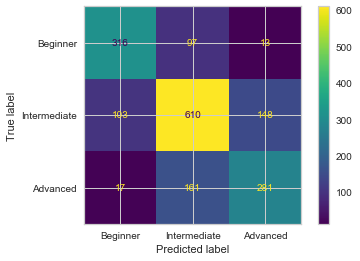

In [24]:
# Try micro 
eval_model(dt6, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')

In [25]:
dt6.classes_

array([0, 1, 2])

In [26]:
# Feature names and class names for decision tree plotting
fn= X_train.columns
cn=['Beginner', 'Intermediate', 'Advanced']

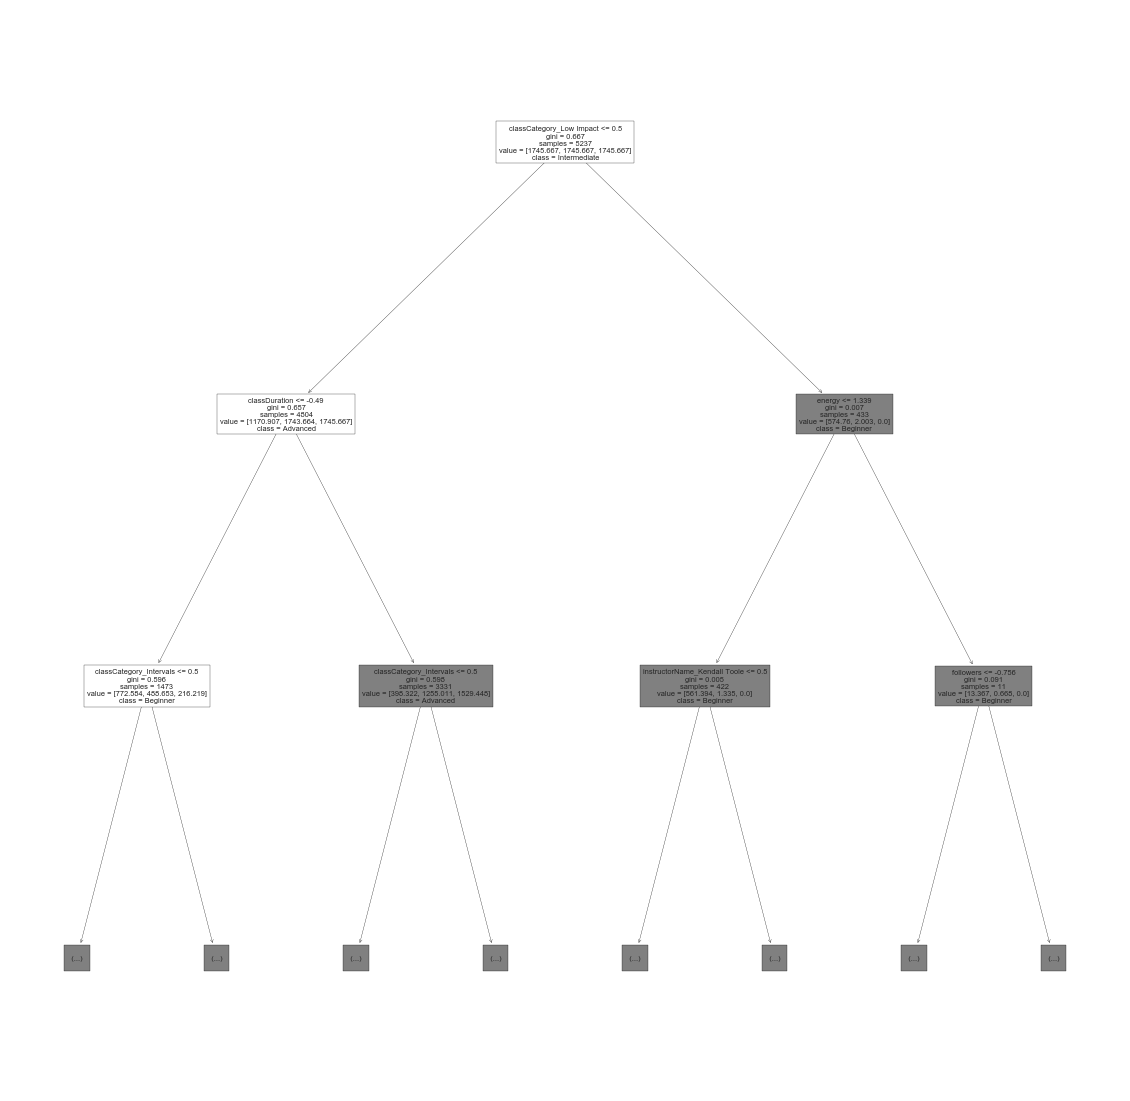

In [27]:
plt.figure(figsize=(20,20))
plot_tree(dt6, max_depth=2, feature_names=fn, class_names=cn)
plt.show()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


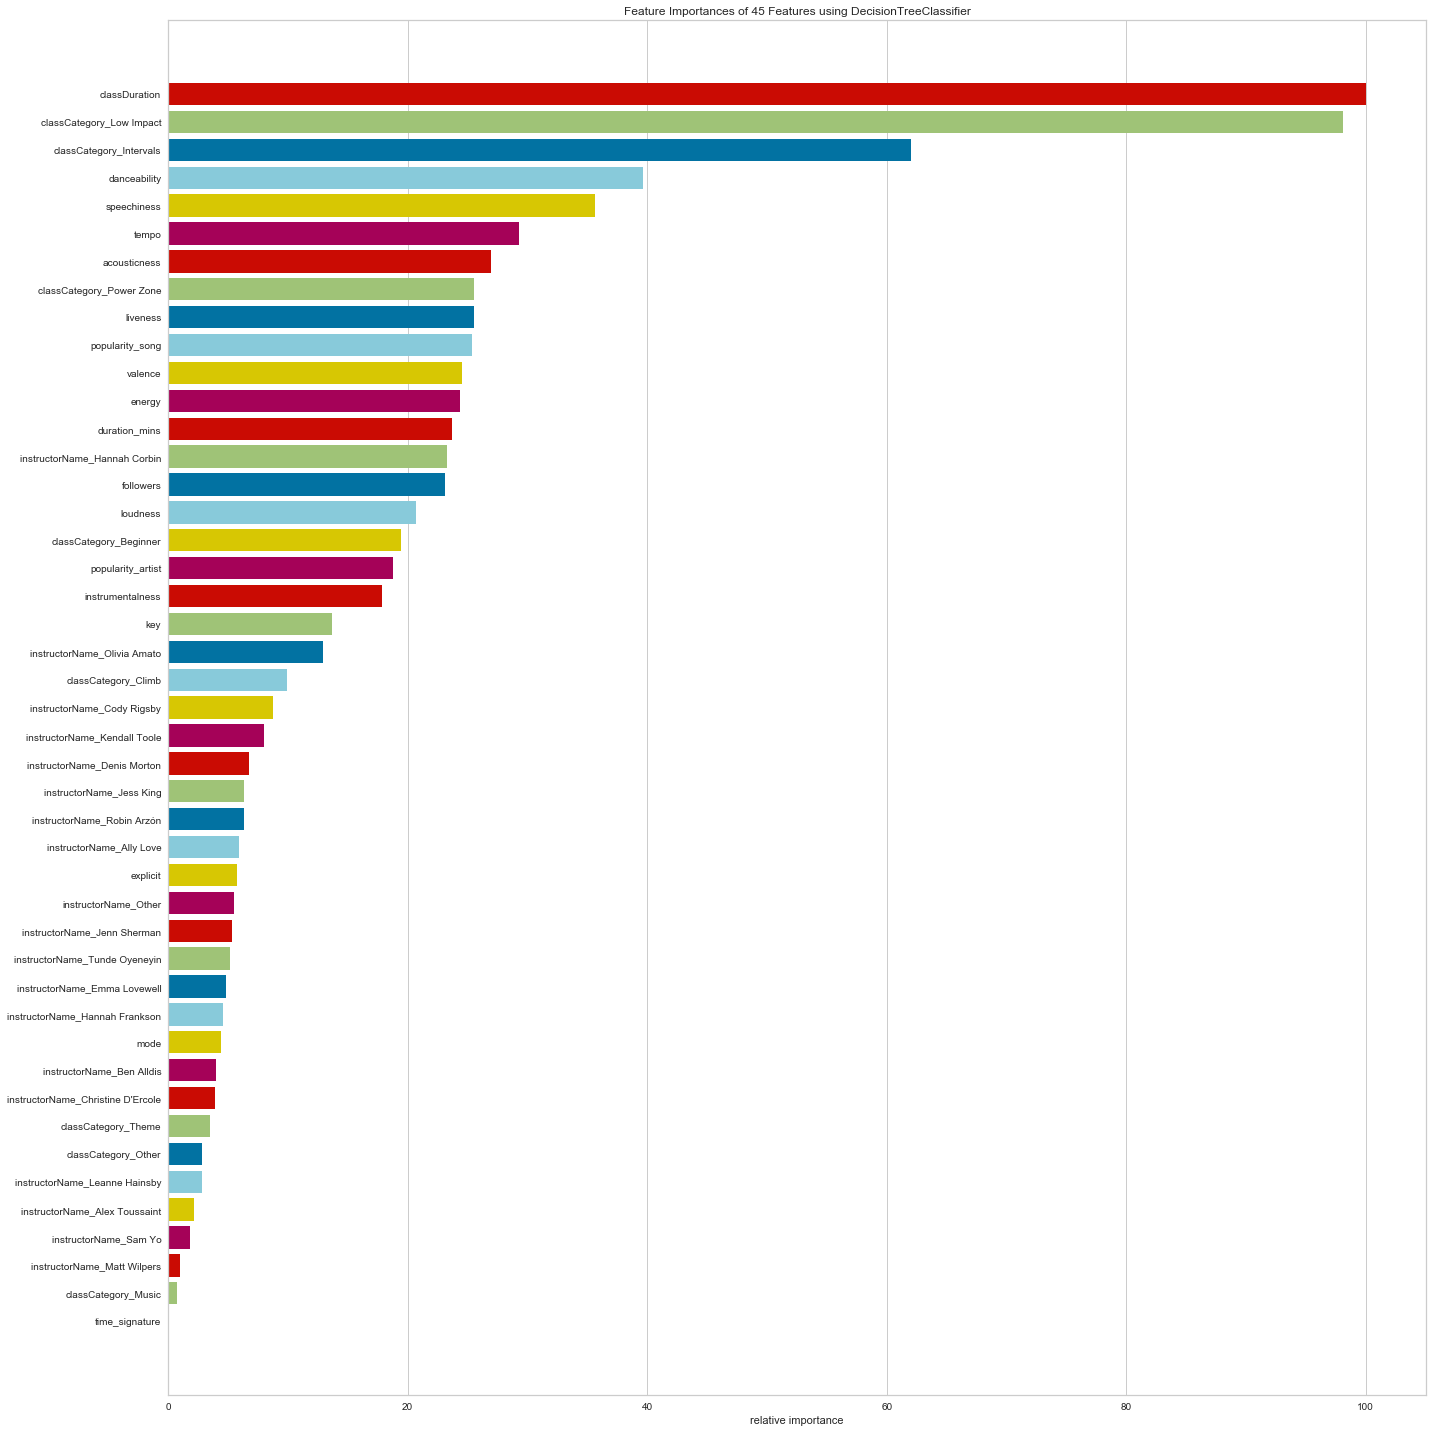

In [28]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(dt6)
viz.fit(X, y)
viz.show()

### Try Winning RF Params on DT for impact

In [29]:
# Instantiate
tuned_dt = DecisionTreeClassifier(max_depth = 9,
                                  max_features = 10, 
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  random_state=42)

# Fit
tuned_dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=10, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

              precision    recall  f1-score   support

    Beginner       0.80      0.63      0.70       426
Intermediate       0.63      0.86      0.73       861
    Advanced       0.72      0.36      0.48       459

    accuracy                           0.67      1746
   macro avg       0.72      0.62      0.64      1746
weighted avg       0.69      0.67      0.66      1746

Train Scores
------------
Accuracy: 0.7164407103303418
F1 Score: 0.7164407103303418
--------------------
Test Scores
-----------
Accuracy: 0.672966781214204
F1 Score: 0.672966781214204
F1 Score Mean Cross Val 3-Fold: 0.6465541103091689


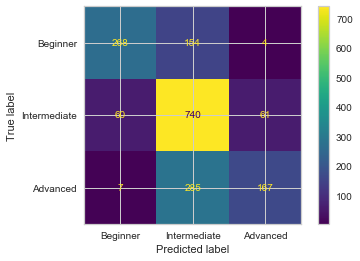

In [30]:
# Try micro 
eval_model(tuned_dt, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# better fit, still overfit
# lost accuracy
# play with max features (depth may overfit more)

#### Increase max features

In [31]:
# Instantiate
tuned_dt2 = DecisionTreeClassifier(max_depth = 9,
                                  max_features = 15,  # increased from 10
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  random_state=42)

# Fit
tuned_dt2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=15, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

              precision    recall  f1-score   support

    Beginner       0.85      0.59      0.70       426
Intermediate       0.67      0.79      0.73       861
    Advanced       0.66      0.62      0.64       459

    accuracy                           0.70      1746
   macro avg       0.73      0.67      0.69      1746
weighted avg       0.71      0.70      0.70      1746

Train Scores
------------
Accuracy: 0.7546305136528547
F1 Score: 0.7546305136528548
--------------------
Test Scores
-----------
Accuracy: 0.6987399770904925
F1 Score: 0.6987399770904925
F1 Score Mean Cross Val 3-Fold: 0.710903787727112


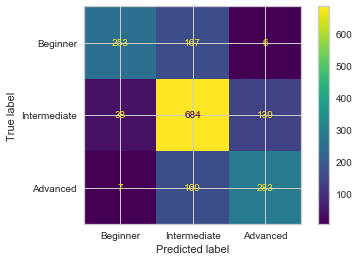

In [32]:
# Try micro 
eval_model(tuned_dt2, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# slightly more overfit
# accuracy up 0.2
# try max features between 10 and 15

#### Increase max features

In [33]:
# Instantiate
tuned_dt3 = DecisionTreeClassifier(max_depth = 9,
                                  max_features = 14, # decreased from 15
                                  min_samples_leaf = 1,
                                  min_samples_split = 20,
                                  random_state=42)

# Fit
tuned_dt3.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=14, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

              precision    recall  f1-score   support

    Beginner       0.77      0.76      0.77       426
Intermediate       0.71      0.70      0.70       861
    Advanced       0.62      0.64      0.63       459

    accuracy                           0.70      1746
   macro avg       0.70      0.70      0.70      1746
weighted avg       0.70      0.70      0.70      1746

Train Scores
------------
Accuracy: 0.7427916746228757
F1 Score: 0.7427916746228755
--------------------
Test Scores
-----------
Accuracy: 0.6993127147766323
F1 Score: 0.6993127147766323
F1 Score Mean Cross Val 3-Fold: 0.6786340944672555


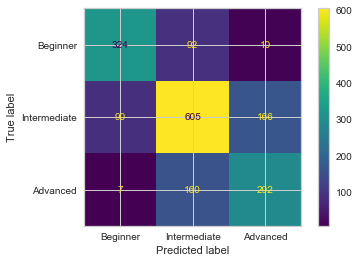

In [34]:
# Try micro 
eval_model(tuned_dt3, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# slightly less overfit (closer to 4% difference)
# played with max features 12-14, 14 was best for highest accuracy and least overfit

#### Note: 
- Decreasing max depth did not do anything good. Killed test accuracy/f1 and increased overfitting
- Increasing Min Samples leaf (2-5) either decreased both train and test scores equally or decreased test score but not train. Thus leaving at 1.

#### Increase Min Samples Split

In [35]:
# Instantiate
tuned_dt4 = DecisionTreeClassifier(max_depth = 9, 
                                  max_features = 14,
                                  min_samples_leaf = 1, 
                                  min_samples_split = 25, #increased from 20
                                  random_state=42)

# Fit
tuned_dt4.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=9, max_features=14, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

              precision    recall  f1-score   support

    Beginner       0.74      0.74      0.74       426
Intermediate       0.69      0.73      0.71       861
    Advanced       0.66      0.58      0.61       459

    accuracy                           0.69      1746
   macro avg       0.69      0.68      0.69      1746
weighted avg       0.69      0.69      0.69      1746

Train Scores
------------
Accuracy: 0.731716631659347
F1 Score: 0.731716631659347
--------------------
Test Scores
-----------
Accuracy: 0.6918671248568156
F1 Score: 0.6918671248568156
F1 Score Mean Cross Val 3-Fold: 0.695242174499552


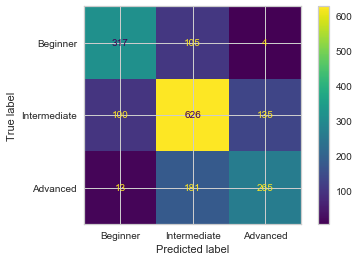

In [36]:
# Try micro 
eval_model(tuned_dt4, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# less overfit by > 1%
# accuracy/f1 slightly down, but f1 cross val is higher

## WINNING DT MODEL

#### Try entropy

In [37]:
# Instantiate
tuned_dt_ent = DecisionTreeClassifier(criterion = 'entropy',
                                      max_depth = 9, 
                                      max_features = 14,
                                      min_samples_leaf = 1, 
                                      min_samples_split = 25,
                                      random_state=42)

# Fit
tuned_dt_ent.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=14, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=25,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

              precision    recall  f1-score   support

    Beginner       0.83      0.54      0.66       426
Intermediate       0.66      0.81      0.73       861
    Advanced       0.67      0.60      0.63       459

    accuracy                           0.69      1746
   macro avg       0.72      0.65      0.67      1746
weighted avg       0.70      0.69      0.68      1746

Train Scores
------------
Accuracy: 0.7196868436127554
F1 Score: 0.7196868436127553
--------------------
Test Scores
-----------
Accuracy: 0.6890034364261168
F1 Score: 0.6890034364261168
F1 Score Mean Cross Val 3-Fold: 0.6849357406915083


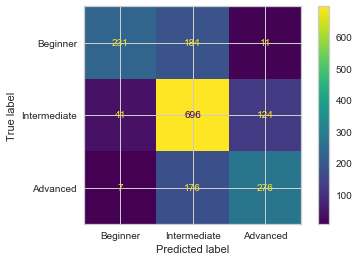

In [38]:
# Try micro 
eval_model(tuned_dt_ent, X_train, X_test, y_train, y_test, ['Beginner', 'Intermediate', 'Advanced'], average='micro')
# less overfit by another 1%
# accuracy/f1 only down 0.002

In [39]:
# Feature names and class names for decision tree plotting
fn= X_train.columns
cn=['Beginner', 'Intermediate', 'Advanced']

In [40]:
# V1 of tree viz/plotting
# plt.figure(figsize=(60,60))
# plot_tree(tuned_dt_ent, max_depth=5, feature_names=fn, class_names=cn, filled=True)
# plt.show()

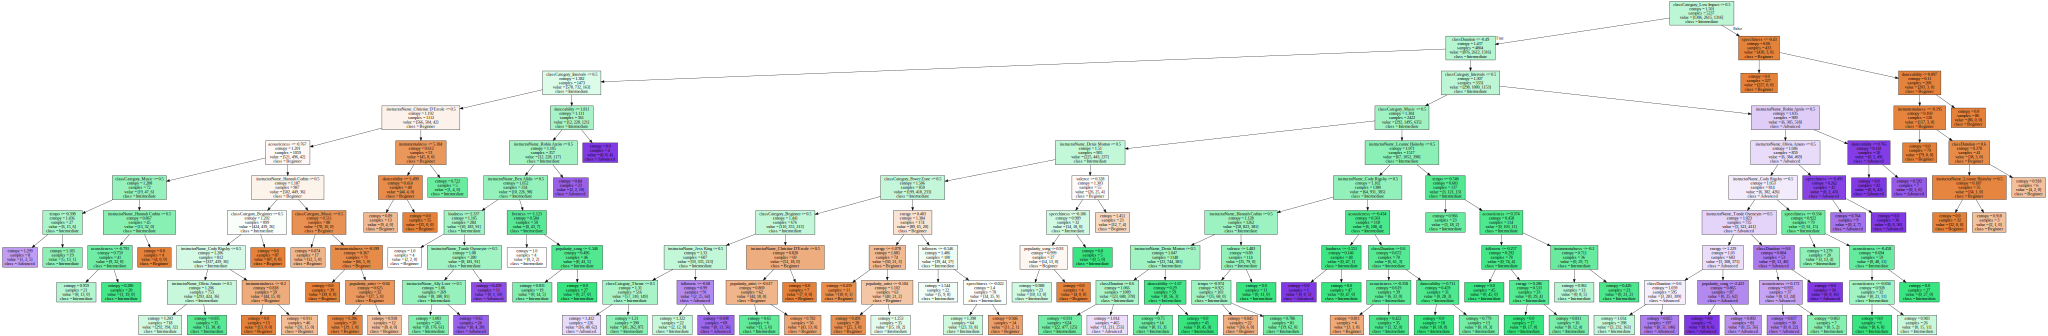

In [41]:
import graphviz
from sklearn import tree
import pylab

# DOT data
dot_data = tree.export_graphviz(tuned_dt_ent, out_file=None, 
                                feature_names=fn,  
                                class_names=cn,
                                max_depth = 10,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png") 

# save graph
pel_tree = graph.render(filename='pel_tree.png')

# show graph
graph

# Source:  https://mljar.com/blog/visualize-decision-tree/

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


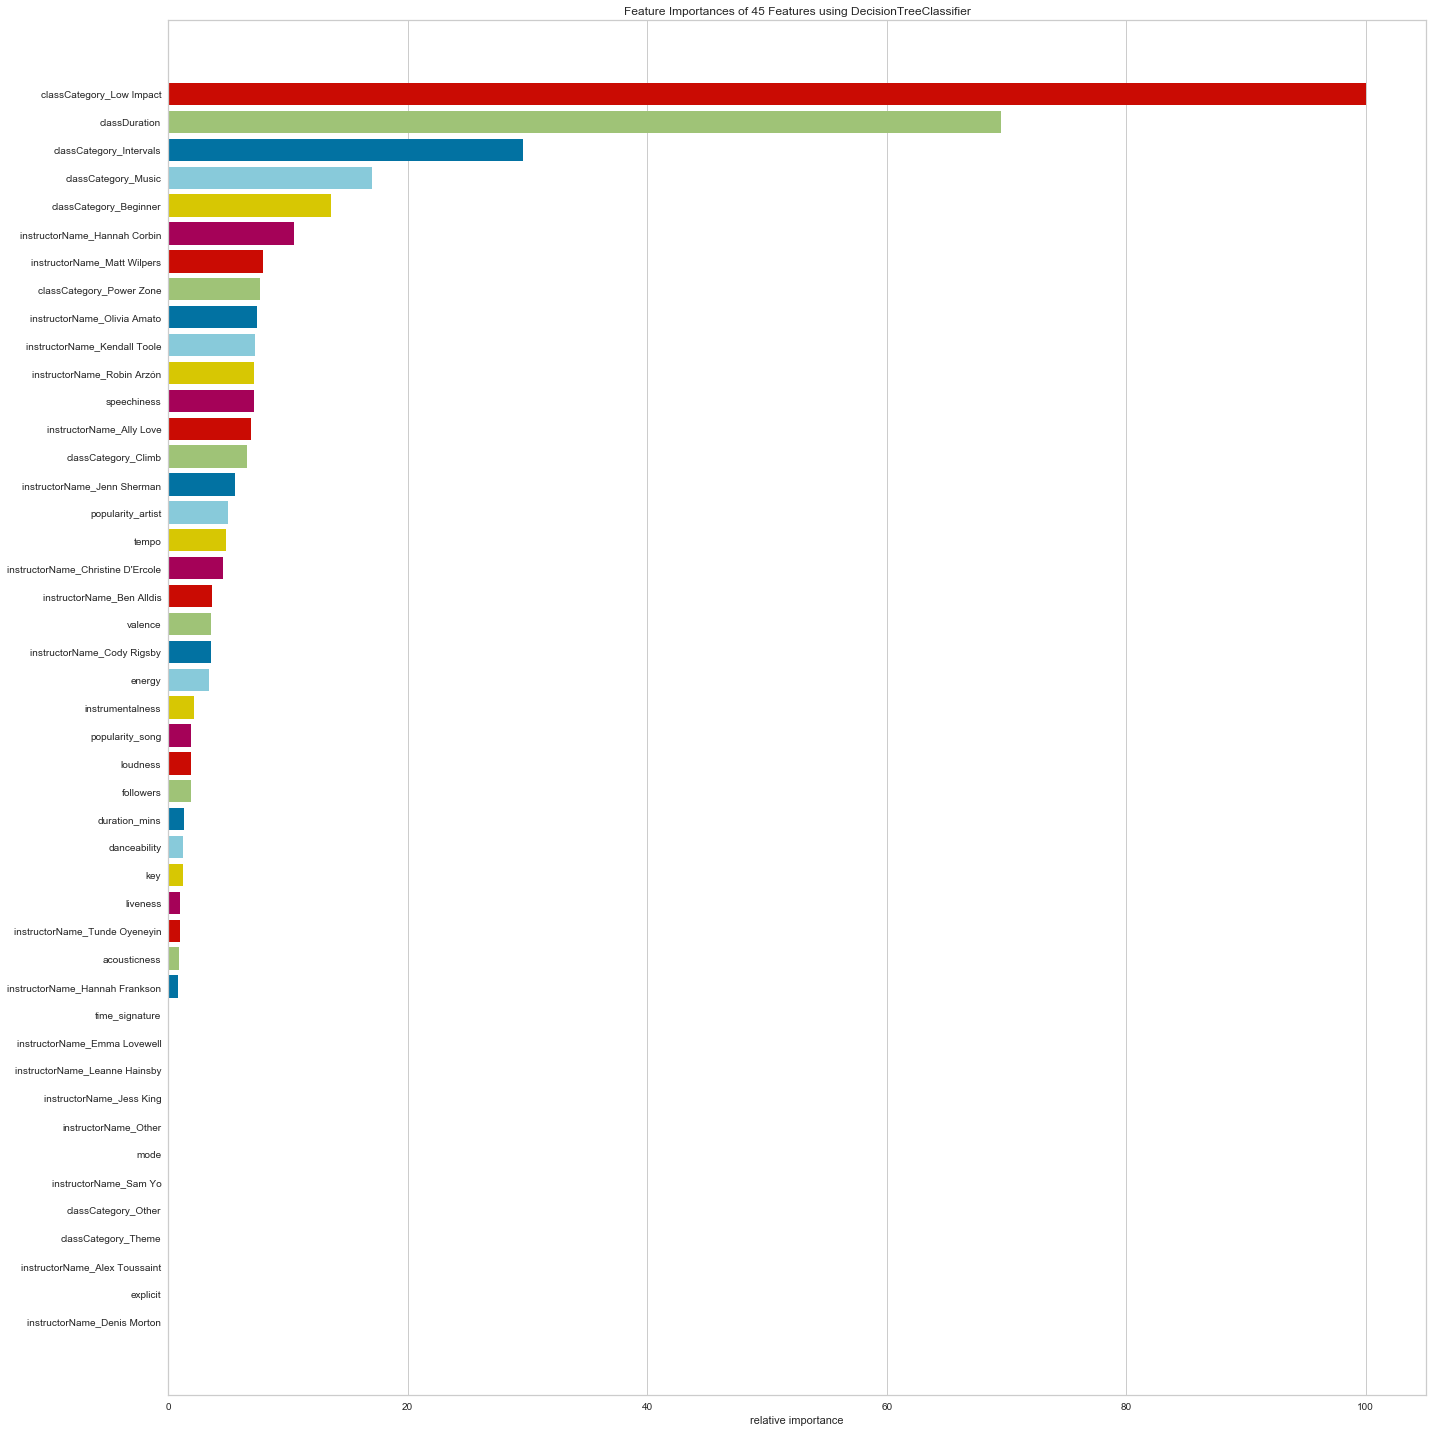

In [42]:
plt.figure(figsize=(20,20))
viz = FeatureImportances(tuned_dt4)
viz.fit(X, y)
viz.show()

#### Learnings from tree
If class is Low Impact, it is Beginner.

If a class is Intervals, difficulty will depend on the duration, instructor and/or the music.

If the class is < 30 mins it will more likely be Beginner/Intermediate, but could be Intermediate or Advanced if high danceability (> 1.811) and a Robin class. 
- Next layer towards Beginner class is if Christine is teaching a non-Intervals class < 30 mins. 
    - Her playlists are more instrumental, so the decision below her is instrumentalness <=5.184. If true, Beginner.

If classDuration is 30 mins or more will lean towards Advanced. Tree goes:
- If class is > 30 mins... still intermediate
- Is the class an Intervals class? If yes, it will be Advanced
    - Next driver is if instructor is Robin? If yes, then next driver is it the instructor is Olivia? Then Cody, then Tunde. 
    - If not Robin, music danceability <= 0.765 (if TRUE, more likely Advanced -- but Advanced either way)
- If class is not Intervals, then if classCategory is Music, then will lean Intermediate (rare that these classes are Advanced)

In [43]:
# Tree split on classDuration <= -0.49. If False, gotes to Intervals then Instructors
# Check out if false subset to see what durations fall under this scaled value for Advanced
classdur_subset = preprocessed[preprocessed['classDuration'] > -0.49]

In [44]:
# preview new df
classdur_subset

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin,classDifficulty_num
2,-0.053947,0.808055,-0.26515,-0.203303,0.733554,-0.189652,0.856351,-1.671005,-0.596627,0.082597,-0.199516,2.143967,0.561003,1.625525,0.034566,-0.665758,-0.713377,-0.222322,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,-0.053947,0.482915,-0.26515,-1.357593,0.334909,0.761399,1.101792,0.690826,-0.606455,-0.841938,-0.199307,-0.061823,-1.013758,1.552091,0.034566,1.766212,1.403223,-0.444950,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7,-0.053947,0.970625,-0.26515,-0.876639,0.406461,-0.189652,1.362923,0.690826,-0.159273,-0.141504,-0.199490,-0.596037,-0.114890,0.646298,0.034566,1.790008,1.403223,0.143843,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
10,-0.053947,0.482915,-0.26515,0.590270,1.091312,-0.665177,0.063991,0.690826,-0.596627,-0.371231,-0.199488,0.713650,1.257800,-0.986481,0.034566,-0.715689,-1.226493,-0.230368,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
11,1.254071,-1.630497,-0.26515,0.409913,-0.145509,0.285873,-0.770397,0.690826,-0.395149,-0.749109,-0.144853,1.023839,-0.428449,0.643766,0.034566,-0.545181,0.120435,-0.632829,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6975,-0.053947,1.377050,-0.26515,-1.032949,-1.607207,0.285873,-3.294293,0.690826,-0.837417,0.935871,-0.198272,-1.056151,1.557422,0.542478,0.034566,-0.547912,-0.392680,1.886750,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6976,1.254071,-0.329936,-0.26515,-1.525926,1.357075,0.285873,1.257013,0.690826,-0.513087,-0.768331,-0.199569,-0.372012,-0.672327,0.807216,0.034566,-0.474217,-0.136123,-1.049309,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
6978,-0.053947,0.401630,-0.26515,-0.551995,-1.310778,-1.140702,-1.171620,0.690826,-0.166644,0.523299,-0.199616,-1.238818,0.561003,-0.017547,0.034566,-0.616071,-1.547190,0.161727,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6981,1.254071,-0.208009,-0.26515,-0.515923,-0.109733,0.761399,-1.422384,0.690826,-0.780905,-0.615024,-0.177325,1.833778,0.738686,-1.056321,0.034566,-0.634988,-0.649238,0.638450,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [45]:
# create variable for original df classDuration Series
og_classdur = df['classDuration']

In [46]:
# Rename for merging
og_classdur.rename('og_classDur', inplace=True)

0       20
1       20
2       30
3       30
4       20
        ..
6978    30
6979    20
6980    20
6981    45
6982    45
Name: og_classDur, Length: 6983, dtype: int64

In [47]:
# Merge original information to subset of scaled classDuration values
ClassDuration_traceback = classdur_subset.merge(og_classdur, how='left', 
                                                left_index=True, right_index=True)

In [48]:
# filter down columns for comparison
only_classdurs = ClassDuration_traceback[['classDuration', 'og_classDur']]

In [49]:
# overview of original classDurations included in subset
only_classdurs['og_classDur'].value_counts()

30    2750
45    1740
60     161
90       7
75       6
Name: og_classDur, dtype: int64

In [50]:
# Compare with all original ClassDurations. Can see all 30 min+ classes are included in the classDuration > -0.49
df['classDuration'].value_counts()

30    2750
20    1749
45    1740
15     318
10     252
60     161
90       7
75       6
Name: og_classDur, dtype: int64

#### Learning: 
If classDuration is 30 mins or more will lean towards Advanced. Tree goes:
- If class is > 30 mins... still intermediate
- Is the class an Intervals class? If yes, it will be Advanced
    - Next driver is if instructor is Robin. If yes, then music danceability <= 0.765 (if TRUE, more likely Advanced)
    - If not Robin, then is it Olivia? If yes, then music speechiness <= -0.495 (if FALSE, more likely Advanced)

### What Artists are associated with the level of danceability for Advanced classes
- May need to redo this to filter down to right class Duration, type, and instructor...


Other ideas to look into based on tree: 
- If not Low Impact and speechiness <= -0.43... = Beginner classes
    - goes further the above logic AND danceability <= 0.097 ... = Beginner class

In [51]:
advanced_subset = preprocessed[(preprocessed['classDuration'] > -0.49) &
                                (preprocessed['classCategory_Intervals'] == 1)]

In [52]:
advanced_subset

,classDuration,popularity_song,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,popularity_artist,duration_mins,classCategory_Beginner,classCategory_Climb,classCategory_Intervals,classCategory_Low Impact,classCategory_Music,classCategory_Other,classCategory_Power Zone,classCategory_Theme,instructorName_Alex Toussaint,instructorName_Ally Love,instructorName_Ben Alldis,instructorName_Christine D'Ercole,instructorName_Cody Rigsby,instructorName_Denis Morton,instructorName_Emma Lovewell,instructorName_Hannah Corbin,instructorName_Hannah Frankson,instructorName_Jenn Sherman,instructorName_Jess King,instructorName_Kendall Toole,instructorName_Leanne Hainsby,instructorName_Matt Wilpers,instructorName_Olivia Amato,instructorName_Other,instructorName_Robin Arzón,instructorName_Sam Yo,instructorName_Tunde Oyeneyin,classDifficulty_num
11,1.254071,-1.630497,-0.26515,0.409913,-0.145509,0.285873,-0.770397,0.690826,-0.395149,-0.749109,-0.144853,1.023839,-0.428449,0.643766,0.034566,-0.545181,0.120435,-0.632829,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
14,-0.053947,0.686127,-0.26515,-1.135151,0.825549,-1.378464,1.457345,0.690826,-0.263698,-0.620650,-0.193247,2.342143,-1.264605,0.561266,0.034566,-0.403807,0.441132,-0.275765,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
25,-0.053947,-0.533149,-0.26515,2.303668,-1.607207,0.523636,0.083043,0.690826,4.887493,-0.744562,-0.199605,1.153085,0.425128,-1.539072,0.034566,-0.521484,-0.392680,0.804526,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
27,1.254071,-0.492506,-0.26515,0.037174,0.314466,1.712449,0.208005,0.690826,-0.237899,-0.719104,-0.197437,-0.716667,0.567971,-0.823930,0.034566,-0.521484,-0.264402,0.774062,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2
37,1.254071,0.239059,-0.26515,0.548187,0.299133,0.999161,-0.258501,-1.671005,-0.135931,-0.560827,-0.172007,-0.915705,0.338028,0.154970,0.034566,-0.314819,-0.136123,-0.047901,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6916,1.254071,0.239059,-0.26515,-0.660209,-0.094401,-1.140702,0.298505,0.690826,-0.342323,-0.524539,-0.199515,0.567172,-1.160085,-0.089428,0.034566,-0.602922,-0.392680,-0.334620,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
6920,-0.053947,-0.411221,-0.26515,1.335749,-0.574819,1.712449,0.180547,0.690826,-0.186301,-0.405925,-0.198409,-0.682201,-0.198506,0.086600,0.034566,-0.850073,-1.932026,-0.190101,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
6933,1.254071,0.523557,-0.26515,-0.305506,0.570007,-0.427414,0.910986,0.690826,0.807573,-0.159788,-0.199528,-0.785597,-0.623552,0.433839,0.034566,-0.662949,-0.007844,-1.286133,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
6957,-0.053947,-0.980217,-0.26515,1.203487,-0.217061,-0.189652,0.680395,0.690826,-0.535201,1.057767,-0.195728,-1.049258,-0.170634,-0.827524,0.034566,-0.699341,-0.520959,0.233407,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


In [53]:
df.columns

Index(['classId', 'className', 'classDescription', 'classDifficulty', 'classDuration', 'classType', 'classLength', 'classLocation', 'classOriginalAirdate', 'classRating', 'classRatingCount', 'instructorName', 'instructorBio', 'classEquipment', 'classSongs', 'classArtists', 'classUrl', 'popularity_song', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'followers', 'popularity_artist', 'duration_mins', 'classCategory', 'classDifficulty_cat', 'classDifficulty_num'], dtype='object')

In [54]:
# get classid, playlist features, and music features from original df to match back
og_adv = df[['classId', 'classSongs', 'classArtists', 
             'popularity_song', 'explicit', 'danceability', 'energy', 'key', 
             'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 
             'liveness', 'valence', 'tempo', 'time_signature', 
             'followers', 'popularity_artist', 'duration_mins']]

In [55]:
# merge
advanced_traceback = advanced_subset.merge(og_adv, how='left',
                                           left_index=True, right_index=True)

In [56]:
# create subset of the original features for analysis
og_advanced_df = advanced_traceback[['classId', 'classSongs', 'classArtists', 'popularity_song_y', 'explicit_y', 
                                    'danceability_y', 'energy_y', 'key_y', 'loudness_y', 'mode_y', 'speechiness_y', 
                                    'acousticness_y', 'instrumentalness_y', 'liveness_y', 'valence_y', 'tempo_y', 
                                    'time_signature_y', 'followers_y', 'popularity_artist_y', 'duration_mins_y']]

og_advanced_df

,classId,classSongs,classArtists,popularity_song_y,explicit_y,danceability_y,energy_y,key_y,loudness_y,mode_y,speechiness_y,acousticness_y,instrumentalness_y,liveness_y,valence_y,tempo_y,time_signature_y,followers_y,popularity_artist_y,duration_mins_y
11,eaa7f79158c74ef6ad60c2142e7c4cd5,"Burn,Tick Tock (feat. 24kGoldn) [Joel Corry Re...","Ellie Goulding,Clean Bandit,Mabel,24kGoldn,Jus...",34.0,0.0,0.6730,0.7210,6.0,-8.0560,1.0,0.05000,0.011300,3.620000e-03,0.20700,0.5080,127.995,4.0,1041910.0,74.0,3.534883
14,a122321acadf4aa98f2ddae4453017eb,"Blame (feat. John Newman),Demons,Time Machine ...","Calvin Harris,John Newman,Imagine Dragons,Alic...",62.5,0.0,0.5445,0.8160,2.5,-4.0805,1.0,0.05535,0.025000,4.210000e-04,0.28350,0.3880,126.985,4.0,1521193.0,76.5,3.704250
25,4a1b06a0f7bc4f059772b49c0481bef1,"Doo Wop (That Thing) (Edit),B.K. Anthem,Tambou...","Lauryn Hill,Foxy Brown,Eve,Lil' Kim,Ivy Queen,...",47.5,0.0,0.8305,0.5780,6.5,-6.5330,1.0,0.26500,0.011785,7.300000e-07,0.21450,0.6305,101.272,4.0,1122245.0,70.0,4.216667
27,af113c8f22dd4bed89accdf60e1f2bd5,"Get Me Bodied (Album Version),Vivrant Thing,To...","Beyoncé,Q-Tip,Kanye West,Lupe Fiasco,Lil' Kim,...",48.0,0.0,0.6420,0.7660,9.0,-6.3100,1.0,0.05640,0.014500,1.440000e-04,0.10600,0.6510,110.027,4.0,1122245.0,71.0,4.202217
37,867bf911bb814bd8b43f91ad1c145667,"Baila Baila Baila,We Own It (Fast & Furious),L...","Ozuna,Daddy Yankee,Farruko,J Balvin,Anuel Aa,2...",57.0,0.0,0.6845,0.7645,7.5,-7.1425,0.0,0.06055,0.031380,1.825000e-03,0.09445,0.6180,122.011,4.0,1822879.0,72.0,3.812333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6916,2be4c305fecd49cc939ca4196c4185ce,"She Lit a Fire,Bennie And The Jets - 2018 Vers...","Lord Huron,Elton John,P!nk,Logic,CNCO,Meghan T...",57.0,0.0,0.5840,0.7260,3.0,-6.1485,1.0,0.05215,0.035250,6.665000e-06,0.18050,0.4030,119.019,4.0,846154.0,70.0,3.676333
6920,6e28693f95594cd793d1aa7605748a05,"All That She Wants,Day 'N' Nite (Nightmare),Lo...","Ryan Riback,Kid Cudi,Malik Adouane,MarT,Mac Be...",49.0,0.0,0.7500,0.6790,9.0,-6.3590,1.0,0.05850,0.047900,7.980000e-05,0.10800,0.5410,121.174,4.0,8268.0,58.0,3.744883
6933,0bcb5a48b05f495991037c1e7e99592a,"Every 1's A Winner - Single Version,Are We Fad...","Hot Chocolate,Keys N Krates,Kanye West,Alessia...",60.5,0.0,0.6135,0.7910,4.5,-5.0555,1.0,0.09895,0.074150,5.805000e-06,0.10200,0.4800,125.425,4.0,642652.0,73.0,3.225000
6957,63aeb72c15d040c68fb7737f454b8069,Me So Bad (feat. Ty Dolla $ign & French Montan...,"Tinashe,Ty Dolla $ign,French Montana,W&W,DJ Ma...",42.0,0.0,0.7390,0.7140,5.0,-5.4670,1.0,0.04430,0.204000,2.570000e-04,0.08670,0.5450,109.983,4.0,519277.0,69.0,3.945767


#### Artist review for advanced classes

Note: this is only for Interval rides that are >= 30 mins long

In [57]:
og_advanced_df_with_artists = og_advanced_df.merge(artist_df, how='left', on='classId')

In [58]:
advanced_artist_list = list(og_advanced_df_with_artists.columns[21:])

In [59]:
# Create dictionary using for loop to grab column name as the dict key and sum of each column as dict value
artist_total_dict = {}

for artist in advanced_artist_list:
    artist_total_dict[artist] = og_advanced_df_with_artists[artist].sum()
       
sorted_artist_count_dict = dict(sorted(artist_total_dict.items(), key=operator.itemgetter(1),reverse=True))

adv_artist_count_df = pd.DataFrame.from_dict(sorted_artist_count_dict, orient='index').reset_index()
adv_artist_count_df.rename(columns={"index": "artist", 0: "classCount"}, inplace = True)
adv_artist_count_df = adv_artist_count_df[adv_artist_count_df['classCount'] > 0]

In [60]:
adv_artist_count_df[adv_dance_artist_count_df['classCount'] >= 100]

NameError: name 'adv_dance_artist_count_df' is not defined

#### Song review for advanced classes

Note: this is only for Interval rides that are >= 30 mins long

In [ ]:
og_advanced_df['classId']

In [ ]:
songs_df

In [ ]:
og_advanced_df_with_songs = og_advanced_df.merge(songs_df, how='left', on='classId')

In [ ]:
advanced_song_list = list(og_advanced_df_with_songs.columns[22:])

In [ ]:
# Create dictionary using for loop to grab column name as the dict key and sum of each column as dict value
song_total_dict = {}

for song in advanced_song_list:
    song_total_dict[song] = og_advanced_df_with_songs[song].sum()
       
sorted_song_count_dict = dict(sorted(song_total_dict.items(), key=operator.itemgetter(1),reverse=True))

adv_song_count_df = pd.DataFrame.from_dict(sorted_song_count_dict, orient='index').reset_index()
adv_song_count_df.rename(columns={"index": "peloton_song_name", 0: "classCount"}, inplace = True)
adv_song_count_df = adv_song_count_df[adv_song_count_df['classCount'] > 0]

In [ ]:
adv_song_count_df

In [ ]:
master_song_df

In [ ]:
# get what you need out of master song df to rematch up to adv_song_count_df
subset_master_songs = master_song_df[['peloton_song_name', 'song_id', 'artist', 'artists', 'popularity', 'duration_ms', 'explicit', 'release_date', 
                                        'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                                        'instrumentalness', 'liveness', 'valence', 'tempo','time_signature']]

In [ ]:
# merge
advanced_song_traceback = adv_song_count_df.merge(subset_master_songs, how='left', on='peloton_song_name')

In [ ]:
advanced_song_traceback[advanced_song_traceback['classCount'] > 15]